In [4]:
#Imports
import numpy as np
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score,f1_score, precision_score, recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegression as SklearnLogReg
from urllib.request import urlretrieve
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Download datasets
url = "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz"  #KDD cup'99 dataset
filename = "kddcup.data_10_percent.gz"
urlretrieve(url, filename)

train_url = "https://github.com/jmnwong/NSL-KDD-Dataset/raw/master/KDDTrain+.txt" #Train Dataset of NSL-KDD Dataset
test_url = "https://github.com/jmnwong/NSL-KDD-Dataset/raw/master/KDDTest+.txt"   #Test dataset of NSL-KDD Dataset

train_file = "KDDTrain+.txt"
test_file = "KDDTest+.txt"

if not os.path.exists(filename):
    print("Downloading 10% KDD Cup'99 dataset...")
    urlretrieve(train_url, train_file)
if not os.path.exists(train_file):
    print("Downloading training dataset of NSL-KDD...")
    urlretrieve(train_url, train_file)
if not os.path.exists(test_file):
    print("Downloading testing dataset of NSL-KDD...")
    urlretrieve(test_url, test_file)
print('Datasets have been downloaded.')

Datasets have been downloaded.


In [6]:
#Custom Logistic Regression Class
class LogisticRegression():
    def __init__(self, alpha=0.01, epochs=1000, threshold=0.5):
        self.alpha = alpha
        self.epochs = epochs
        self.threshold = threshold  # default threshold
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.random.randn(n_features) * 0.01
        self.bias = 0

        for _ in tqdm(range(self.epochs), desc="Training Progress", unit="epoch"):
            linear_model = np.dot(X, self.weights) + self.bias
            y_pred = self.sigmoid(linear_model)

            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)
            self.weights -= self.alpha * dw
            self.bias -= self.alpha * db

    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return self.sigmoid(linear_model)

    def predict(self, X, threshold=None):
        if threshold is None:
            threshold = self.threshold
        return (self.predict_proba(X) >= threshold).astype(int)


In [8]:
#Function to plot variation of f1-score as decision threshold is varied in the Logistic Regression model
def plot_threshold_vs_metrics(y_true, y_probs):
    thresholds = np.linspace(0.01, 0.99, 99)
    precisions, recalls, f1s = [], [], []

    for t in thresholds:
        preds = (y_probs >= t).astype(int)
        precisions.append(precision_score(y_true, preds))
        recalls.append(recall_score(y_true, preds))
        f1s.append(f1_score(y_true, preds))

    best_idx = np.argmax(f1s)
    best_thresh = thresholds[best_idx]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions, label="Precision", linestyle="--", marker="o")
    plt.plot(thresholds, recalls, label="Recall", linestyle="--", marker="x")
    plt.plot(thresholds, f1s, label="F1 Score", linewidth=2, color='black')

    plt.axvline(best_thresh, color='red', linestyle=':', label=f"Best Threshold = {best_thresh:.2f}")
    plt.title("Threshold vs Precision, Recall, and F1 Score")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Best Threshold (by F1): {best_thresh:.2f}")
    return best_thresh

In [9]:
#Function written to plot confusion matrix using matplotlib and seaborn
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

In [10]:
#Function to calculate and display metrics accuracy, precision,recall, f1-score
def calculateAndDisplayEvaluationMetrics(y_test, y_pred,title):
    accuracy = accuracy_score(y_test,y_pred)*100
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Model Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    plot_confusion_matrix(y_test, y_pred, title)

In [12]:
# (a) Evluating on 1st dataset- KDD Cup '99

#defining columns (naming each of the 41 features+ the target label vector)
KDDCup_columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate",
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"
]

# Loading dataset in dataframe using pandas
df = pd.read_csv(filename, names=KDDCup_columns)

#Removes duplicate rows(data cleaning)
print(df.shape)
df = df.drop_duplicates()  
print(df.shape)

print(df['label'].value_counts().to_dict())  # Returns all unique labels in the dataset with their count as a 

#Therefore, we can see that the KDD Dataset contains lot of redundant(duplicate) data and is highly imbalanced



(494021, 42)
(145586, 42)
{'normal.': 87832, 'neptune.': 51820, 'back.': 968, 'teardrop.': 918, 'satan.': 906, 'warezclient.': 893, 'ipsweep.': 651, 'smurf.': 641, 'portsweep.': 416, 'pod.': 206, 'nmap.': 158, 'guess_passwd.': 53, 'buffer_overflow.': 30, 'warezmaster.': 20, 'land.': 19, 'imap.': 12, 'rootkit.': 10, 'loadmodule.': 9, 'ftp_write.': 8, 'multihop.': 7, 'phf.': 4, 'perl.': 3, 'spy.': 2}


In [13]:
#Preprocessing Data

# Convert categorical columns using Label Encoding (since, ML Models can only take in numerical features and not text)
categorical_cols = ["protocol_type", "service", "flag"]
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

# Converting target labels to binary, ie, 0 if normal and 1 if attack
df["label"] = df["label"].apply(lambda x: 0 if x == "normal." else 1)

X = df.drop("label", axis=1).values # Extracting features
y = df["label"].values #Extracting labels

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 80% train, 20% test dataset split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Training Progress: 100%|██████████| 1000/1000 [00:10<00:00, 94.06epoch/s]


Model Accuracy: 97.64%
Precision: 0.9874
Recall: 0.9526
F1 Score: 0.9697


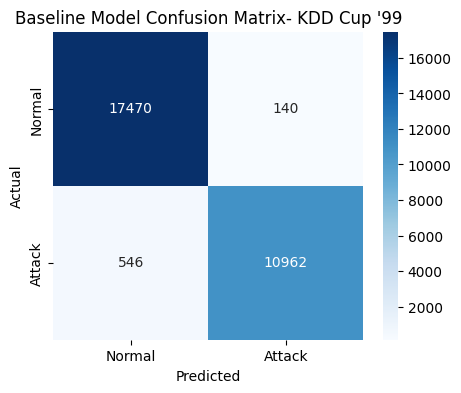

In [15]:
# Initial model(baseline model- No hyperparameter tuning)
log_reg = LogisticRegression(alpha=0.01, epochs=1000)
log_reg.fit(X_train, y_train)

# Get predictions
y_pred = log_reg.predict(X_test)

# Show final evaluation
calculateAndDisplayEvaluationMetrics(y_test, y_pred, f"Baseline Model Confusion Matrix- KDD Cup '99")

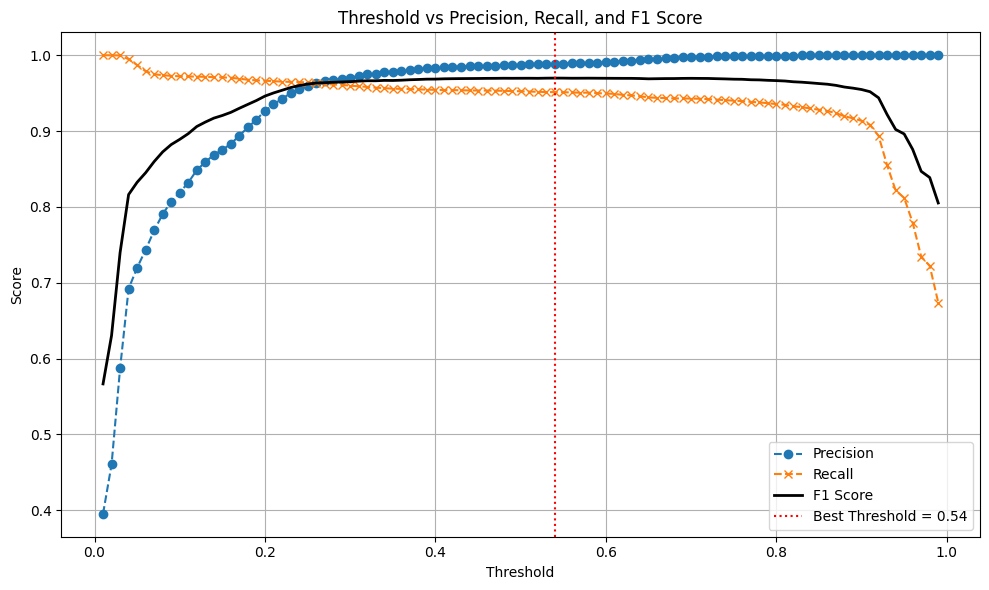

Best Threshold (by F1): 0.54
Model Accuracy: 97.66%
Precision: 0.9891
Recall: 0.9514
F1 Score: 0.9699


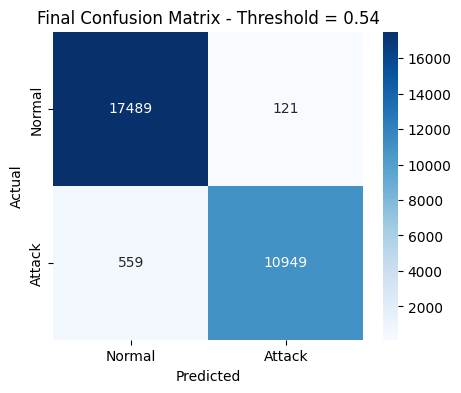

In [16]:
# Get predicted probabilities
y_probs = log_reg.predict_proba(X_test)

# Tune threshold to further improve performance
best_thresh = plot_threshold_vs_metrics(y_test, y_probs)

# Predict using best threshold
y_pred_thresh = (y_probs >= best_thresh).astype(int)

# Final evaluation
calculateAndDisplayEvaluationMetrics(y_test, y_pred_thresh, f"Final Confusion Matrix - Threshold = {best_thresh:.2f}")


Model Accuracy: 98.83%
Precision: 0.9892
Recall: 0.9810
F1 Score: 0.9851


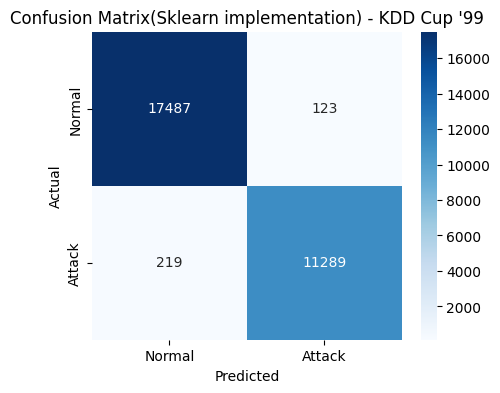

In [17]:
#Comparing with sklearn inbuilt logistic regression function
log_reg = SklearnLogReg(max_iter=500)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
calculateAndDisplayEvaluationMetrics(y_test, y_pred, "Confusion Matrix(Sklearn implementation) - KDD Cup '99" )


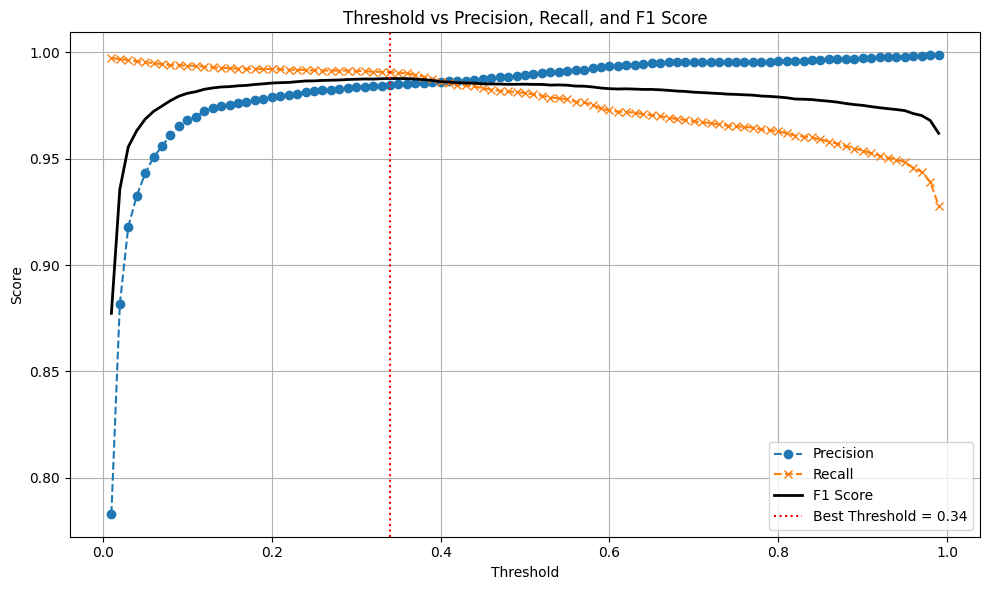

Best Threshold (by F1): 0.34
Model Accuracy: 99.03%
Precision: 0.9848
Recall: 0.9907
F1 Score: 0.9877


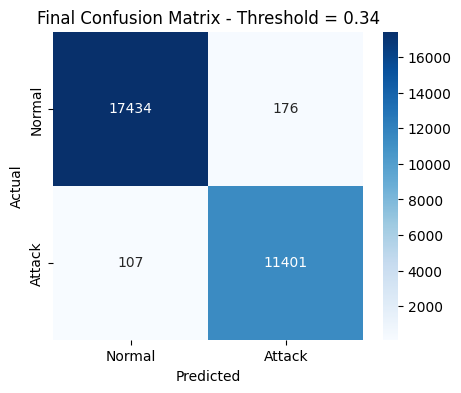

In [18]:
# Get only the probabilities for class 1
y_probs = log_reg.predict_proba(X_test)[:, 1]

# Tune threshold
best_thresh = plot_threshold_vs_metrics(y_test, y_probs)

# Predict with custom threshold
y_pred_thresh = (y_probs >= best_thresh).astype(int)

# Final evaluation
calculateAndDisplayEvaluationMetrics(y_test, y_pred_thresh, f"Final Confusion Matrix - Threshold = {best_thresh:.2f}")


In [19]:
# (B) Evaluating on 2nd dataset- NSL-KDD

KDDNSL_columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate",
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate", "dst_host_srv_serror_rate", "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate", "class", "difficulty"
]

#Converting train and test files into dataframes
train_df = pd.read_csv(train_file, names=KDDNSL_columns, header=None) 
test_df = pd.read_csv(test_file, names=KDDNSL_columns, header=None)

#Dropping the difficulty column as not relevant for training
train_df.drop("difficulty", axis=1, inplace=True)
test_df.drop("difficulty", axis=1, inplace=True)

#Removes duplicate rows(data cleaning)
print(df.shape)
df = df.drop_duplicates()  
print(df.shape)

print(train_df['class'].value_counts().to_dict())  # Returns all unique labels in the dataset with their count as a dictionary

#Clearly, we can see that this dataset is more balanced and does not contain duplicates as such



(145586, 42)
(145585, 42)
{'normal': 67343, 'neptune': 41214, 'satan': 3633, 'ipsweep': 3599, 'portsweep': 2931, 'smurf': 2646, 'nmap': 1493, 'back': 956, 'teardrop': 892, 'warezclient': 890, 'pod': 201, 'guess_passwd': 53, 'buffer_overflow': 30, 'warezmaster': 20, 'land': 18, 'imap': 11, 'rootkit': 10, 'loadmodule': 9, 'ftp_write': 8, 'multihop': 7, 'phf': 4, 'perl': 3, 'spy': 2}


In [20]:
#Data Preprocessing

# Label encode categorical columns(to convert features to numerical values)
categorical_cols = ["protocol_type", "service", "flag"]
encoder = LabelEncoder()

for col in categorical_cols:
    train_df[col] = encoder.fit_transform(train_df[col])  # Fit + transform on train
    test_df[col] = encoder.transform(test_df[col])  # Transform only on test (NO FIT)

# Convert class labels to binary (0 for normal, 1 for attack)
train_df["class"] = train_df["class"].apply(lambda x: 0 if x == "normal" else 1)
test_df["class"] = test_df["class"].apply(lambda x: 0 if x == "normal" else 1)

# Split features and labels
X_train = train_df.drop("class", axis=1).values
y_train = train_df["class"].values
X_test = test_df.drop("class", axis=1).values
y_test = test_df["class"].values

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  
X_test = scaler.transform(X_test) 


Training Progress: 100%|██████████| 1000/1000 [00:07<00:00, 131.49epoch/s]


Model Accuracy: 76.22%
Precision: 0.9266
Recall: 0.6323
F1 Score: 0.7516


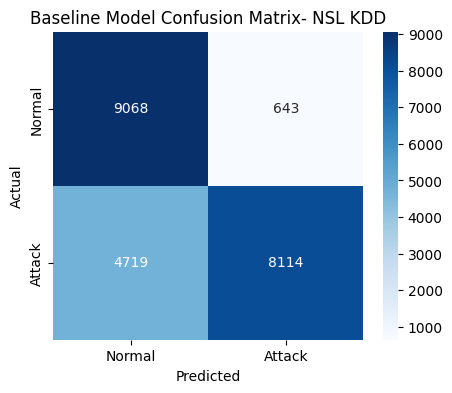

In [22]:
# Initial model(baseline model- No hyperparameter tuning)
log_reg = LogisticRegression(alpha=0.01, epochs=1000)
log_reg.fit(X_train, y_train)

# Get predictions
y_pred = log_reg.predict(X_test)

# Show final evaluation
calculateAndDisplayEvaluationMetrics(y_test, y_pred, f"Baseline Model Confusion Matrix- NSL KDD")

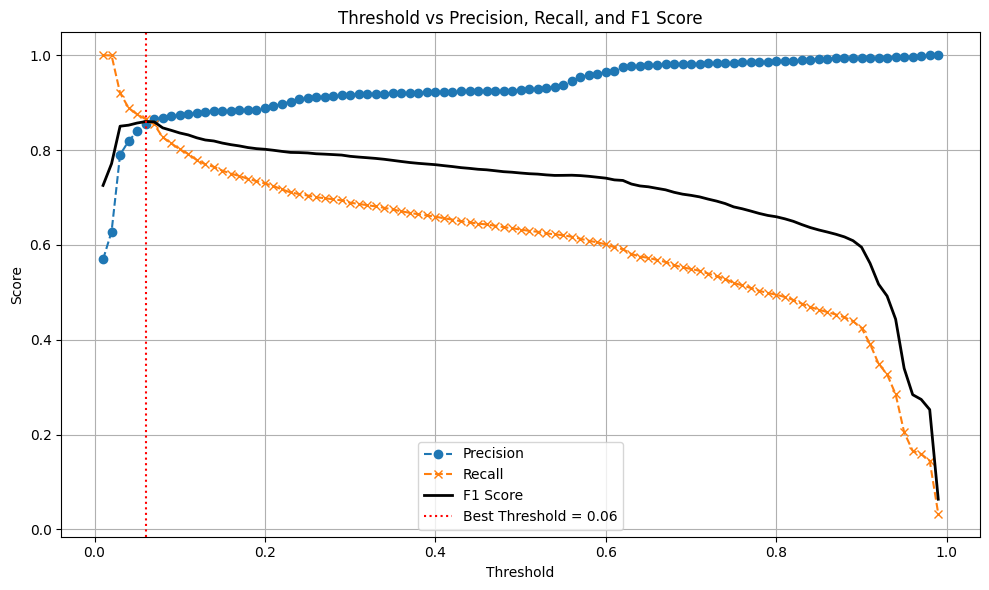

Best Threshold (by F1): 0.06
Model Accuracy: 83.98%
Precision: 0.8548
Recall: 0.8655
F1 Score: 0.8601


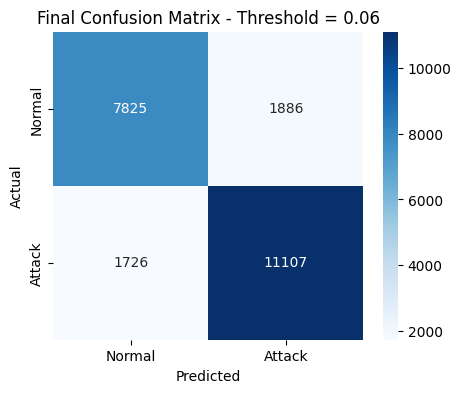

In [23]:
# Get predicted probabilities
y_probs = log_reg.predict_proba(X_test)

# Tune threshold to further improve performance
best_thresh = plot_threshold_vs_metrics(y_test, y_probs)

# Predict using best threshold
y_pred_thresh = (y_probs >= best_thresh).astype(int)

# Final evaluation
calculateAndDisplayEvaluationMetrics(y_test, y_pred_thresh, f"Final Confusion Matrix - Threshold = {best_thresh:.2f}")


Model Accuracy: 75.39%
Precision: 0.9252
Recall: 0.6175
F1 Score: 0.7407


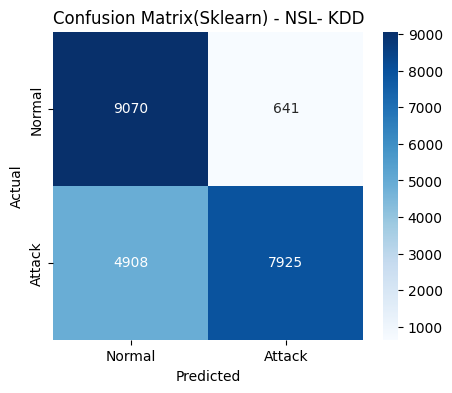

In [25]:
#Comparing with sklearn,

log_reg = SklearnLogReg(max_iter=500)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

# Compute metrics
calculateAndDisplayEvaluationMetrics(y_test, y_pred, "Confusion Matrix(Sklearn) - NSL- KDD")

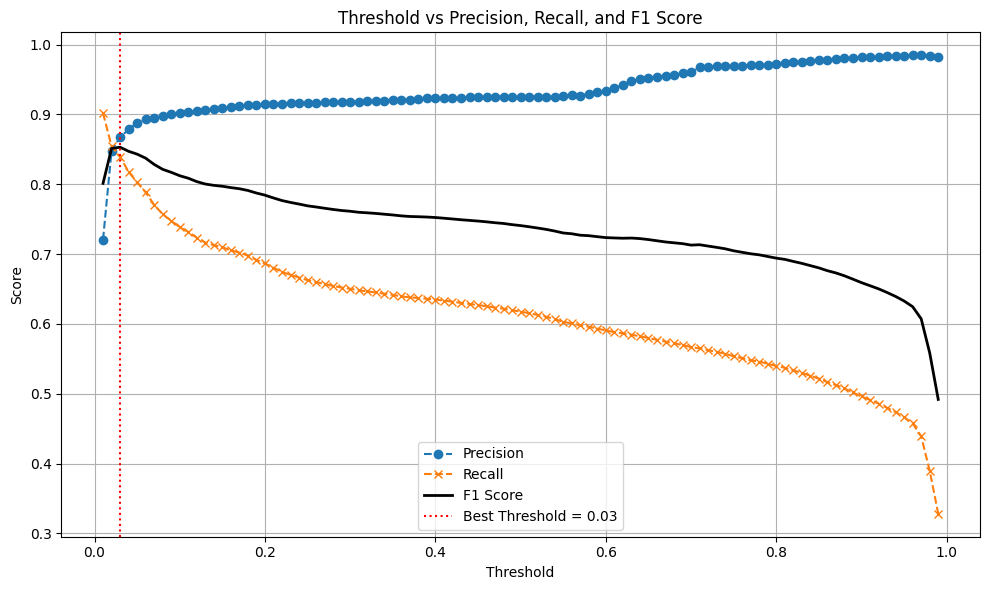

Best Threshold (by F1): 0.03
Model Accuracy: 83.53%
Precision: 0.8671
Recall: 0.8392
F1 Score: 0.8529


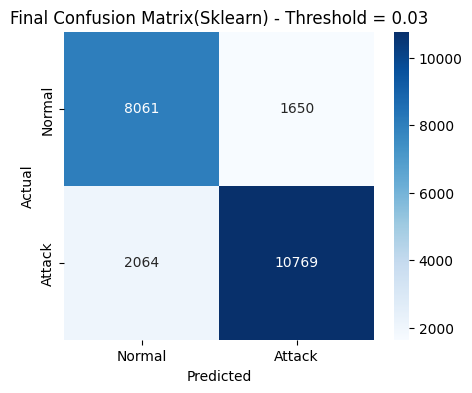

In [27]:
# Get predicted probabilities
y_probs = log_reg.predict_proba(X_test)[:, 1]

# Tune threshold to further improve performance
best_thresh = plot_threshold_vs_metrics(y_test, y_probs)

# Predict using best threshold
y_pred_thresh = (y_probs >= best_thresh).astype(int)

# Final evaluation
calculateAndDisplayEvaluationMetrics(y_test, y_pred_thresh, f"Final Confusion Matrix(Sklearn) - Threshold = {best_thresh:.2f}")
